In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import io
import json
import mne

from scipy.io import loadmat
from scipy.signal import welch

from pyriemann.embedding import SpectralEmbedding
from pyriemann.classification import MDM
from pyriemann.estimation import Covariances

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [4]:
file_path = r'C:\Users\brian\OneDrive - University of Tennessee\Desktop\Research\Python program\RTI-\test\data'
files = os.listdir(file_path)
print(files)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\brian\\OneDrive - University of Tennessee\\Desktop\\Research\\Python program\\EdenBand\\test\\data'

In [ ]:
# a function to extract data from a single file
def get_data(file):
    file_path = r'C:\Users\brian\OneDrive - University of Tennessee\Desktop\Research\Python program\EdenBand\test\data\\'
    data = loadmat(file_path + file)
    print(data)

    S = data['SIGNAL'][:, 1:17]
    stim_close = data['SIGNAL'][:, 17]
    stim_open = data['SIGNAL'][:, 18]
    stim = 1 * stim_close + 2 * stim_open

    chnames = [
        'Fp1',
        'Fp2',
        'Fc5',
        'Fz',
        'Fc6',
        'T7',
        'Cz',
        'T8',
        'P7',
        'P3',
        'Pz',
        'P4',
        'P8',
        'O1',
        'Oz',
        'O2',
        'stim']
    chtypes = ['eeg'] * 16 + ['stim']
    X = np.concatenate([S, stim[:, None]], axis=1).T

    info = mne.create_info(ch_names=chnames, sfreq=512,
                           ch_types=chtypes,
                           verbose=False)
    raw = mne.io.RawArray(data=X, info=info, verbose=False)
    

    # return the article as a dictionary to identify the article by the id.
    # The key format is 'articleID#'  --->> # represents integer numbers
    return raw

In [ ]:
raw = get_data(files[0])

In [61]:
raw

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"16 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,256.00 Hz


In [62]:
raw.describe()

<RawArray | 17 x 63104 (123.2 s), ~8.2 MB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  Fp1   EEG   µV    1919117919.90  2181048034.68  2275398925.80  2422695739.77  2577585205.10
 1  Fp2   EEG   µV    -2557157959.00  -2456960937.47  -2362735351.55  -2231222045.88  -2104002685.50
 2  Fc5   EEG   µV    217782211.30  430085990.91  510669525.15  560539947.51  795885375.98
 3  Fz    EEG   µV    -7108479492.20  -6816313232.43  -6781700683.60  -6714244018.57  -6612576660.20
 4  Fc6   EEG   µV    -6534169433.60  -6374752075.20  -6266024902.35  -6208651123.05  -6095611328.10
 5  T7    EEG   µV    -11849524414.00  -11518110351.50  -11400988769.50  -11323991699.50  -11208399414.00
 6  Cz    EEG   µV    -2934821289.10  -2712221618.65  -2555023925.80  -2486022583.05  -2391815185.50
 7  T8    EEG   µV    -14278633789.00  -13982040039.00  -13955098633.00  -13930370361.50  -13821010742.00
 8  P7    EEG   µV    -2057885986.30  -1844913513.15  -1780144714

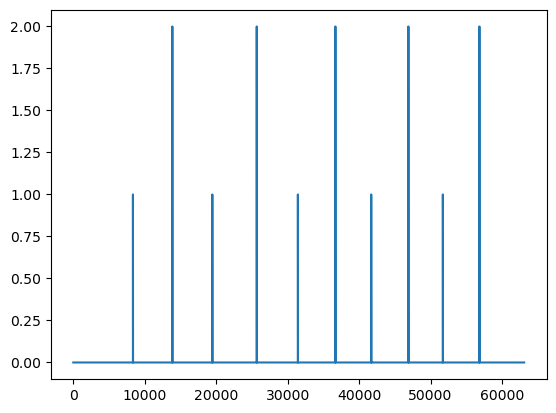

In [63]:
plt.plot(raw.get_data()[-1])

Using data from preloaded Raw for 10 events and 769 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\brian\AppData\Local\Temp\ipykernel_9904\3160642554.py:15: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_closed = epochs['closed'].get_data()
C:\Users\brian\AppData\Local\Temp\ipykernel_9904\3160642554.py:18: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_opened = epochs['open'].get_data()


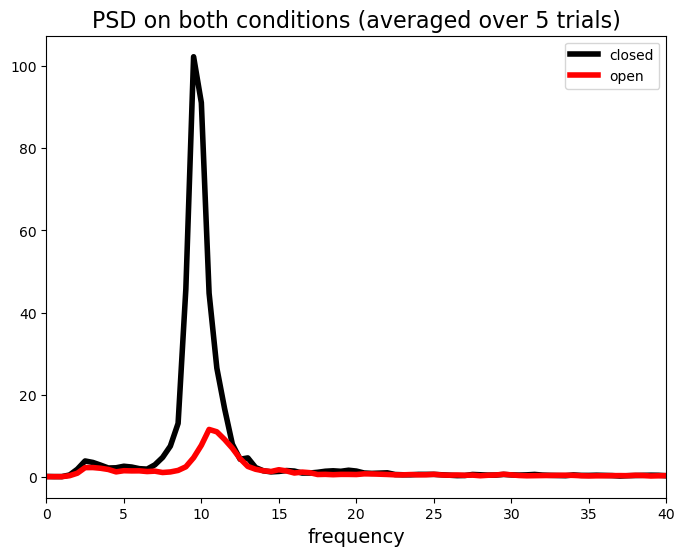

In [64]:
# filter data and resample
fmin = 3
fmax = 40
raw.filter(fmin, fmax, verbose=False)
raw.resample(sfreq=128, verbose=False)

# detect the events and cut the signal into epochs
events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
event_id = {'closed': 1, 'open': 2}
epochs = mne.Epochs(raw, events, event_id, tmin=2.0, tmax=8.0, baseline=None,
                    verbose=False)
epochs.load_data().pick_channels(['Oz'])

# estimate the averaged spectra for each condition
X_closed = epochs['closed'].get_data()
f, S_closed = welch(X_closed, fs=epochs.info['sfreq'], axis=2)
S_closed = np.mean(S_closed, axis=0).squeeze()
X_opened = epochs['open'].get_data()
f, S_opened = welch(X_opened, fs=epochs.info['sfreq'], axis=2)
S_opened = np.mean(S_opened, axis=0).squeeze()

# plot the results
fig = plt.figure(facecolor='white', figsize=(8, 6))
plt.plot(f, S_closed, c='k', lw=4.0, label='closed')
plt.plot(f, S_opened, c='r', lw=4.0, label='open')
plt.xlim(0, 40)
plt.xlabel('frequency', fontsize=14)
plt.title('PSD on both conditions (averaged over 5 trials)', fontsize=16)
plt.legend()
plt.show()

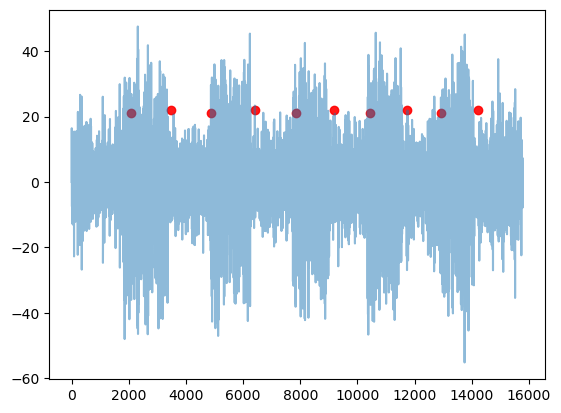

In [65]:
plt.plot(raw.get_data()[-2],alpha=0.5)
plt.scatter(events[:,0],events[:,2]+20,c='r',alpha=0.9)
plt.show()

In [66]:
epochs

Number of events,10
Events,closed: 5open: 5
Time range,2.000 – 8.000 s
Baseline,off


In [67]:
epochs.get_data().shape

C:\Users\brian\AppData\Local\Temp\ipykernel_9904\2796709754.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data().shape


(10, 1, 769)

C:\Users\brian\AppData\Local\Temp\ipykernel_9904\939796157.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  plt.plot(epochs.get_data()[-2].T)


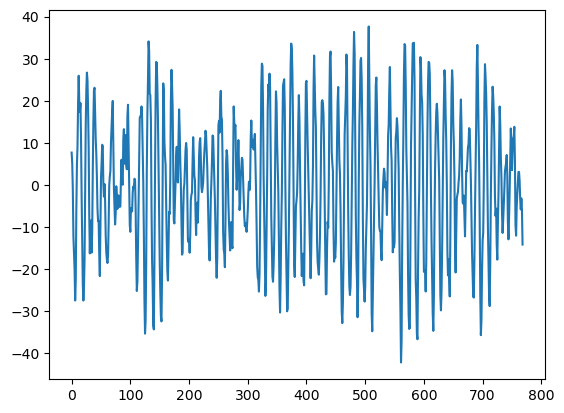

In [68]:
plt.plot(epochs.get_data()[-2].T)

In [69]:
import warnings
warnings.filterwarnings("ignore")

raw = data_1

# filter data and resample
fmin = 3
fmax = 40
raw.filter(fmin, fmax, verbose=False)
raw.resample(sfreq=128, verbose=False)

# detect the events and cut the signal into epochs
events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
event_id = {'closed': 1, 'open': 2}
epochs = mne.Epochs(raw, events, event_id, tmin=2.0, tmax=8.0, baseline=None,
                    verbose=False)
epochs.load_data().pick_channels(['Oz'])

# get trials and labels
X = epochs.get_data().ravel().reshape((10,769))
y = events[:, -1]

# cross validation
skf = StratifiedKFold(n_splits=5)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
scr = cross_val_score(clf, X, y, cv=skf)
preds = cross_val_predict(clf, X, y, cv=skf)

# print results of classification
print('subject', files[0])
print('mean accuracy :', scr.mean())

Using data from preloaded Raw for 10 events and 769 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
subject subject_00.mat
mean accuracy : 1.0


In [70]:
epochs.get_data().shape

(10, 1, 769)

In [71]:
X.shape

(10, 769)

In [72]:
events.shape

(10, 3)

In [73]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,shuffle=True)
model = SVC(gamma='auto')
SS = StandardScaler().fit(X_train)
X_train = SS.transform(X_train)
model.fit(X_train,y_train)
y_pred = model.predict(SS.transform(X_test))
print(accuracy_score(y_test, y_pred))

1.0


In [74]:
model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Dec 13 22:14:22 2018', '__version__': '1.0', '__globals__': [], 'SIGNAL': array([[ 0.00000000e+00, -1.66397969e+04,  1.07526416e+03, ...,
        -1.97763594e+04,  0.00000000e+00,  0.00000000e+00],
       [ 1.95312500e-03, -1.66351543e+04,  1.07932727e+03, ...,
        -1.97789062e+04,  0.00000000e+00,  0.00000000e+00],
       [ 3.90625000e-03, -1.66370605e+04,  1.07823169e+03, ...,
        -1.97734941e+04,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.33994141e+02, -1.83469707e+04, -4.33083130e+02, ...,
        -2.30812480e+04,  0.00000000e+00,  0.00000000e+00],
       [ 2.33996094e+02, -1.83304590e+04, -4.15464417e+02, ...,
        -2.30606270e+04,  0.00000000e+00,  0.00000000e+00],
       [ 2.33998047e+02, -1.83295391e+04, -4.17637817e+02, ...,
        -2.30502891e+04,  0.00000000e+00,  0.00000000e+00]])}
Using data from preloaded Raw for 10 events and 769 original time points ...
0 bad epochs dropp

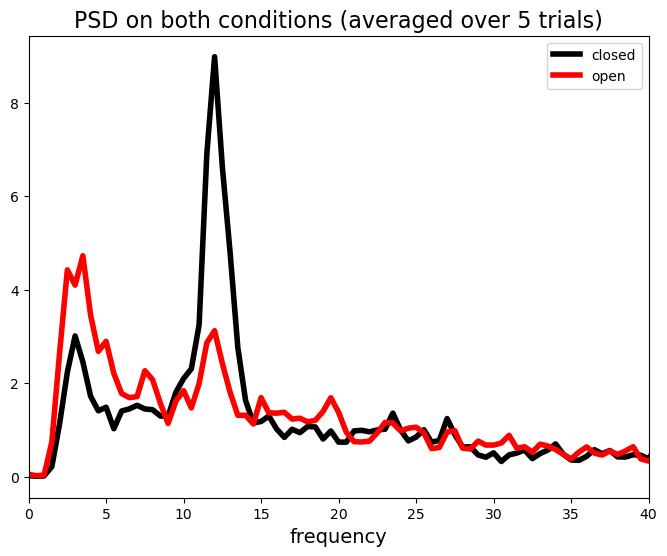

0.5


In [75]:
data_2 = get_data(files[1])
raw = data_2

# filter data and resample
fmin = 3
fmax = 40
raw.filter(fmin, fmax, verbose=False)
raw.resample(sfreq=128, verbose=False)

# detect the events and cut the signal into epochs
events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
event_id = {'closed': 1, 'open': 2}
epochs = mne.Epochs(raw, events, event_id, tmin=2.0, tmax=8.0, baseline=None,
                    verbose=False)
epochs.load_data().pick_channels(['Oz'])

# estimate the averaged spectra for each condition
X_closed = epochs['closed'].get_data()
f, S_closed = welch(X_closed, fs=epochs.info['sfreq'], axis=2)
S_closed = np.mean(S_closed, axis=0).squeeze()
X_opened = epochs['open'].get_data()
f, S_opened = welch(X_opened, fs=epochs.info['sfreq'], axis=2)
S_opened = np.mean(S_opened, axis=0).squeeze()

# plot the results
fig = plt.figure(facecolor='white', figsize=(8, 6))
plt.plot(f, S_closed, c='k', lw=4.0, label='closed')
plt.plot(f, S_opened, c='r', lw=4.0, label='open')
plt.xlim(0, 40)
plt.xlabel('frequency', fontsize=14)
plt.title('PSD on both conditions (averaged over 5 trials)', fontsize=16)
plt.legend()
plt.show()

# get trials and labels
X = epochs.get_data().ravel().reshape((10,769))
y = events[:, -1]

y_pred = model.predict(SS.transform(X))
print(accuracy_score(y, y_pred))

In [81]:
subject = files[0]

# filter data and resample
fmin = 3
fmax = 40
raw.filter(fmin, fmax, verbose=False)
raw.resample(sfreq=128, verbose=False)

# detect the events and cut the signal into epochs
events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
event_id = {'closed': 1, 'open': 2}
epochs = mne.Epochs(raw, events, event_id, tmin=2.0, tmax=8.0, baseline=None,
                    verbose=False, preload=True)
epochs.pick_types(eeg=True)

# get trials and labels
X = epochs.get_data()
y = events[:, -1]

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


subject subject_00.mat
mean accuracy : 0.8


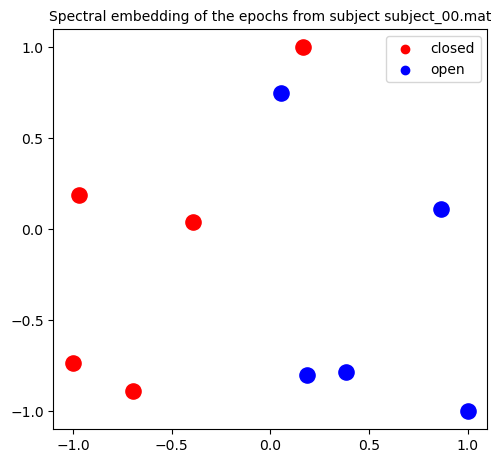

In [82]:
# cross validation
skf = StratifiedKFold(n_splits=5)
clf = make_pipeline(Covariances(estimator='lwf'), MDM())
scr = cross_val_score(clf, X, y, cv=skf)

# print results of classification
print('subject', subject)
print('mean accuracy :', scr.mean())

# get the spectral embedding of the epochs
C = Covariances(estimator='lwf').fit_transform(X)
emb = SpectralEmbedding(metric='riemann').fit_transform(C)

# scatter plot of the embedded points
fig = plt.figure(facecolor='white', figsize=(5.6, 5.2))
colors = {1: 'r', 2: 'b'}
for embi, yi in zip(emb, y):
    plt.scatter(embi[0], embi[1], s=120, c=colors[yi])
labels = {1: 'closed', 2: 'open'}
for yi in np.unique(y):
    plt.scatter([], [], c=colors[yi], label=labels[yi])
plt.xticks([-1, -0.5, 0.0, +0.5, 1.0])
plt.yticks([-1, -0.5, 0.0, +0.5, 1.0])
plt.legend()
plt.title(
    'Spectral embedding of the epochs from subject ' +
    str(subject),
    fontsize=10)

plt.show()